In [159]:
# 데이터분석
import pandas as pd
import numpy as np 

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc 

import os
import warnings
import random

# ML/DL 모델 및 sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 경고 끄기
warnings.filterwarnings(action='ignore')

# 데이터프레임 제한 풀기
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_seq_items', None)

### 전처리

In [160]:
# 월 평균값 있을때
df = pd.read_csv('./우양 - 주가,코스피원본.csv')
df.date = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%Y-%m')
df = df.set_index('date')

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.transform(df)
df_scaled = pd.DataFrame(scaled, columns=['pricemm','kospimm'])
df = df.reset_index('date')
df_scaled.insert(0,'date', df['date'] )

df = df.merge(df_scaled,how='left')
df.head()

,date,price_month,kospi_month,pricemm,kospimm
0,2019-11,4888.750000,2128.794762,0.501737,0.232308
1,2019-12,4082.000000,2147.013500,0.221417,0.244681
2,2020-01,3942.000000,2203.442500,0.172771,0.283006
3,2020-02,4240.500000,2167.123500,0.276491,0.258339
4,2020-03,3444.772727,1786.746364,0.000000,0.000000


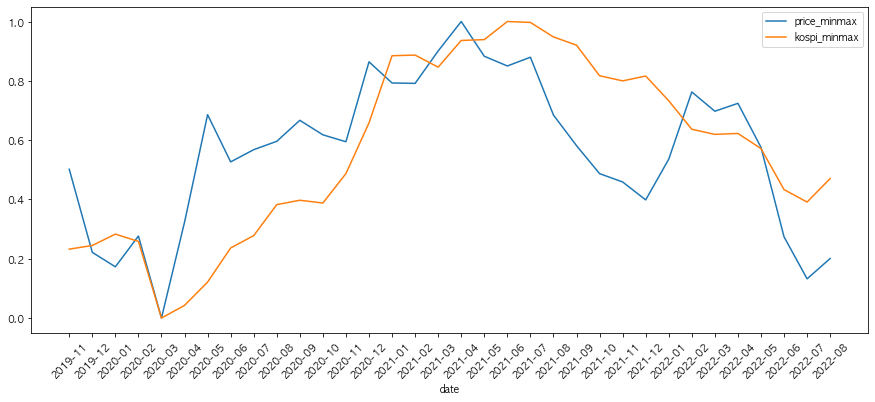

In [161]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.size'] = 23
# plt.rcParams['figure.figsize'] = (13, 8) # figsize 고정
sns.lineplot(data=df, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df, x="date", y="kospimm", label='kospi_minmax')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

In [162]:
# 스케일링한 주가와 코스피 지수의 기울기(가격 변화량/시간 변화량) 도출
for i in range(len(df)-1): 
    df.loc[i+1,'price_slope'] = df.loc[i+1,'pricemm']-df.loc[i,'pricemm']
    df.loc[i+1,'kospi_slope'] = df.loc[i+1,'kospimm']-df.loc[i,'kospimm']

df = df.bfill()

for i in range(len(df)):
    df.loc[i,'k_s - p_s'] = df.loc[i,'kospi_slope'] - df.loc[i,'price_slope']

    if df.loc[i,'price_slope'] < df.loc[i,'kospi_slope']:
        df.loc[i, 'downturn'] = 1
    else:
        df.loc[i, 'downturn'] = 0

df.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0


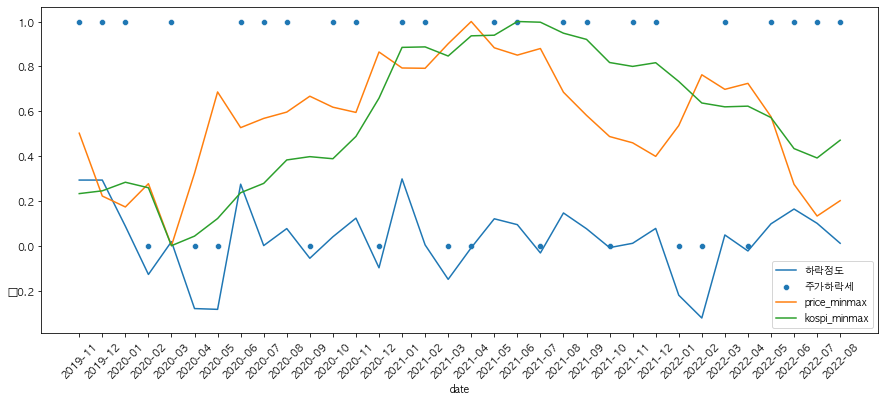

In [163]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.lineplot(data=df, x="date", y="k_s - p_s", label='하락정도')
sns.scatterplot(data=df, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df, x="date", y="kospimm", label='kospi_minmax')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

In [164]:
df.to_csv('yvalue.csv',index=False)

- downturn이 target(y값) feature입니다.

#### feature importance로 feature selection

(27, 4)
(7, 4)
1    0.666667
0    0.333333
Name: downturn, dtype: float64
1    0.571429
0    0.428571
Name: downturn, dtype: float64
정확도 :  0.7142857142857143


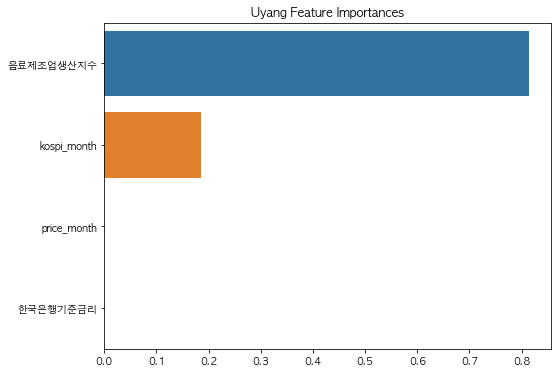

,downturn,price_month,kospi_month,음료제조업생산지수,한국은행기준금리
date,,,,,
2019-11-01,1,4888.750000,2128.794762,93.2,1.25
2019-12-01,1,4082.000000,2147.013500,90.2,1.25
2020-01-01,1,3942.000000,2203.442500,97.1,1.25
2020-02-01,0,4240.500000,2167.123500,90.0,1.25
2020-03-01,1,3444.772727,1786.746364,92.7,0.75


In [165]:
# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('./Uyang_feature_importance.csv')
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)

from sklearn.tree import DecisionTreeClassifier

# train, test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

# 0,1이 고르게 나누어졌을까?
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델 학습
model = DecisionTreeClassifier(max_depth=3, random_state=1)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
print('정확도 : ', accuracy_score(y_pred, y_test))

# feature importance 확인
ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('Uyang Feature Importances') # 그래프 제목을 변경해주세요
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()
df_f.head()

- accuracy가 0.7 이 넘는 데이터에서 나온 feature만 확인
- 음료제조업생산지수 하나 밖에 없습니다.

(27, 22)
(7, 22)
1    0.666667
0    0.333333
Name: downturn, dtype: float64
1    0.571429
0    0.428571
Name: downturn, dtype: float64
정확도 :  0.5714285714285714


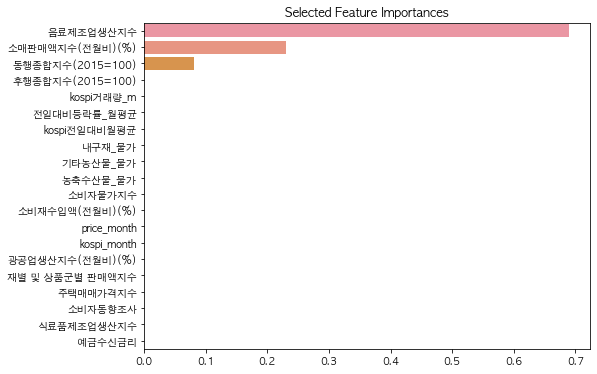

,downturn,price_month,kospi_month,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리
date,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,1,4888.750000,2128.794762,3.7,1.62,110.2,93.2,101.5,90.0,116.0,113.0,0.3,0.3,115.1,-3.3,99.481,92.064,95.365,98.976,0.213333,0.013810,511316.6190,1.25
2019-12-01,1,4082.000000,2147.013500,3.7,1.60,111.0,90.2,101.1,90.3,117.1,113.5,0.7,1.4,115.4,0.9,99.719,93.953,96.100,99.085,5.485500,0.258500,509437.6000,1.25
2020-01-01,1,3942.000000,2203.442500,3.8,1.54,108.9,97.1,104.7,90.6,113.5,114.0,0.5,0.3,115.6,-0.8,100.090,95.630,97.590,99.680,-3.933000,-0.174500,654803.4000,1.25
2020-02-01,0,4240.500000,2167.123500,3.3,1.43,102.1,90.0,97.6,90.9,106.2,113.3,-0.6,-2.8,115.9,-0.6,100.160,94.730,95.820,100.210,-6.600000,-0.308000,697988.3000,1.25
2020-03-01,1,3444.772727,1786.746364,3.7,1.27,112.6,92.7,79.9,91.4,105.4,112.3,-0.3,-3.5,116.0,-2.9,99.940,96.570,93.740,98.770,-10.562273,-0.479091,776864.7727,0.75


In [166]:
# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('./Uyang_features.csv')
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)

from sklearn.tree import DecisionTreeClassifier

# train, test split
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델
model = DecisionTreeClassifier(max_depth=4, random_state=1)
model.fit(X_train, y_train)
# model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print('정확도 : ',accuracy_score(y_pred, y_test))

ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('Selected Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()
df_f.head()

- 식료품 마켓컬리 테마주라고 해석됩니다. 거시적인 경제 지표의 영향을 상대적으로 덜 받는다고 해석합니다.
### 하락 팩터 찾기

In [167]:
## feature selection된 데이터 MinMaxScaling

df_f = df_f.drop(['price_month', 'downturn', 'kospi_month'], axis=1)

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df_f)
scaled = scaler.transform(df_f)
df_scaled = pd.DataFrame(scaled, columns=list(df_f.columns))

# 정규화한 데이터에 날짜 열 추가
df_scaled.insert(0,'date', df['date'] )

In [168]:
 df_scaled.head()

,date,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리
0,2019-11,0.444444,0.373272,0.553719,0.235119,0.767196,0.000000,0.595506,0.204724,0.524590,0.535211,0.000000,0.000000,0.004409,0.000000,0.115836,0.050000,0.511308,0.470982,0.102737,0.375
1,2019-12,0.444444,0.364055,0.586777,0.145833,0.756614,0.020270,0.657303,0.244094,0.590164,0.690141,0.022556,0.545455,0.030000,0.076552,0.146628,0.076456,0.680542,0.676296,0.101280,0.375
2,2020-01,0.481481,0.336406,0.500000,0.351190,0.851852,0.040541,0.455056,0.283465,0.557377,0.535211,0.037594,0.324675,0.069892,0.144513,0.209049,0.220874,0.378213,0.312976,0.214012,0.375
3,2020-02,0.296296,0.285714,0.219008,0.139881,0.664021,0.060811,0.044944,0.228346,0.377049,0.098592,0.060150,0.350649,0.077419,0.108040,0.134897,0.349515,0.292603,0.200959,0.247503,0.375
4,2020-03,0.444444,0.211982,0.652893,0.220238,0.195767,0.094595,0.000000,0.149606,0.426230,0.000000,0.067669,0.051948,0.053763,0.182607,0.047759,0.000000,0.165416,0.057400,0.308673,0.125


In [169]:
df.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0


In [170]:
df_result = df.merge(df_scaled, how='left')
df_result.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0,0.444444,0.373272,0.553719,0.235119,0.767196,0.000000,0.595506,0.204724,0.524590,0.535211,0.000000,0.000000,0.004409,0.000000,0.115836,0.050000,0.511308,0.470982,0.102737,0.375
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0,0.444444,0.364055,0.586777,0.145833,0.756614,0.020270,0.657303,0.244094,0.590164,0.690141,0.022556,0.545455,0.030000,0.076552,0.146628,0.076456,0.680542,0.676296,0.101280,0.375
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0,0.481481,0.336406,0.500000,0.351190,0.851852,0.040541,0.455056,0.283465,0.557377,0.535211,0.037594,0.324675,0.069892,0.144513,0.209049,0.220874,0.378213,0.312976,0.214012,0.375
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0,0.296296,0.285714,0.219008,0.139881,0.664021,0.060811,0.044944,0.228346,0.377049,0.098592,0.060150,0.350649,0.077419,0.108040,0.134897,0.349515,0.292603,0.200959,0.247503,0.375
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0,0.444444,0.211982,0.652893,0.220238,0.195767,0.094595,0.000000,0.149606,0.426230,0.000000,0.067669,0.051948,0.053763,0.182607,0.047759,0.000000,0.165416,0.057400,0.308673,0.125


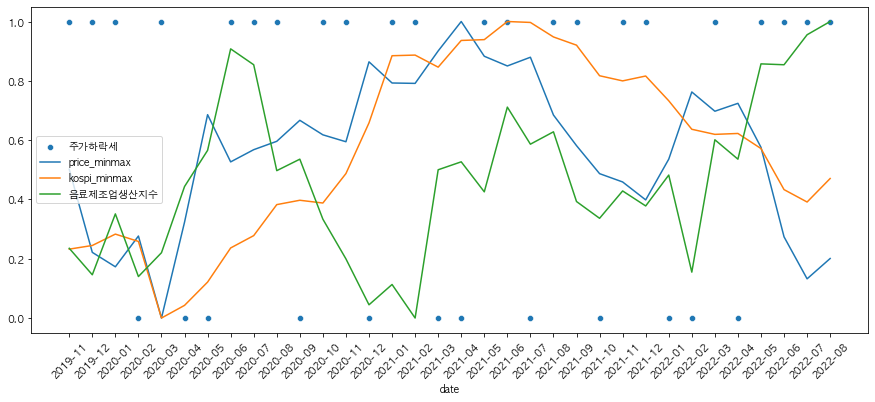

In [171]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="음료제조업생산지수", label='음료제조업생산지수')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

생산지수는 기준시점에 대한 품목별 생산수량의 신장을, 기준시점에 있어서의 부가가치(생산금액의 원재료비 등을 차감한 것)를 웨이트로 하여 가중 평균한 것이며, 생산의 수량적 확대의 정도를 나타냅니다.

우양은 음료, 농축액, 스무디 총 32개의 제품이 있습니다.

음료제조업생산지수가 하락할 때 같이 하락하는 시점 (21년 6월)이 존재하긴 하지만, 같은 경향이 아닌 부분이 더 많습니다. 

종합적인 지수라서 소기업인 우양을 잘 반영하지 못한다고 생각할 수 있습니다.

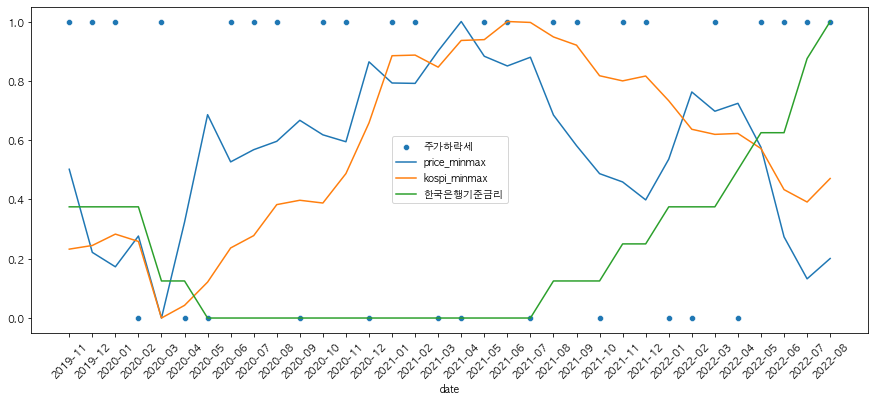

In [172]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="한국은행기준금리", label='한국은행기준금리')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

기준 금리가 하락할 때 (20년 2월)에 주가가 상승하였고, 기준 금리 상승 시그널이 있을 때(21년 5월) 그리고 실제로 기준 금리가 상승하자(21년 7월) 주가가 하락합니다.

올해 본격적으로 한은 총재 교체 이후 미국의 빅스텝과 더불어 금리가 상승하자 주가가 하락합니다. (22년 4월)

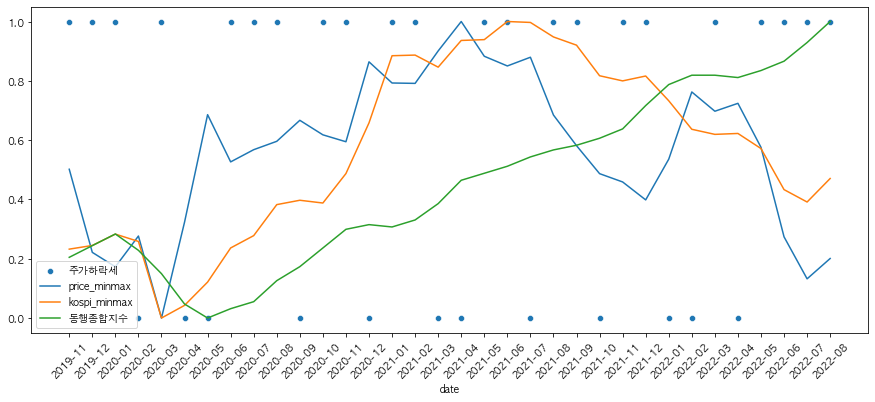

In [173]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="동행종합지수(2015=100)", label='동행종합지수')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

삭제하죠

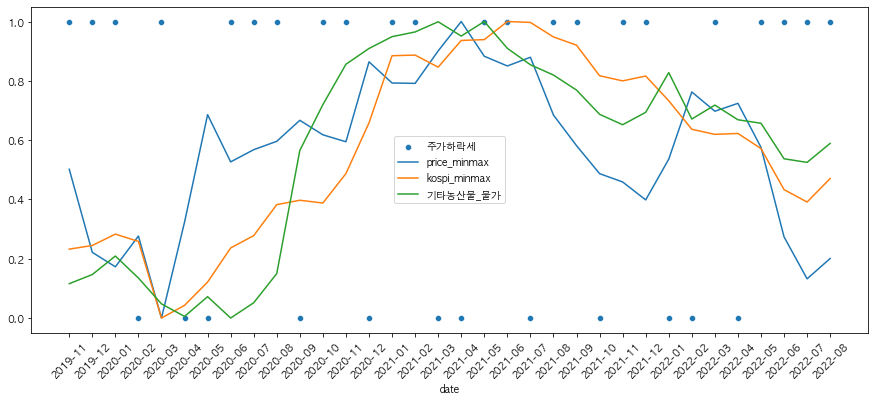

In [180]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="기타농산물_물가", label='기타농산물_물가')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

기타농산물 물가지수가 하락할 때 주가도 하락세를 탄다. (검증)

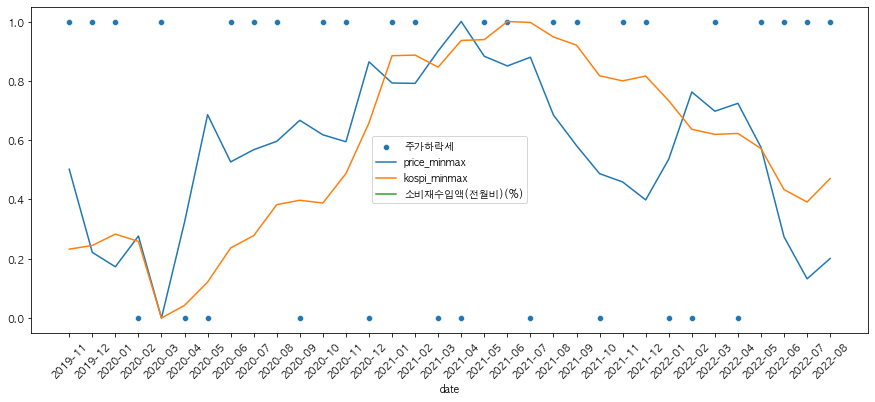

In [178]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, y="소비재수입액(전월비)(%)", label='소비재수입액(전월비)(%)')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

버리죠

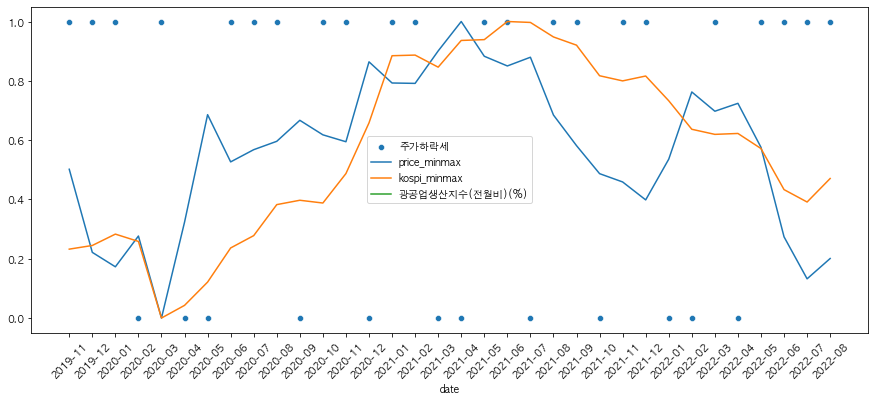

In [179]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, y="광공업생산지수(전월비)(%)", label='광공업생산지수(전월비)(%)')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

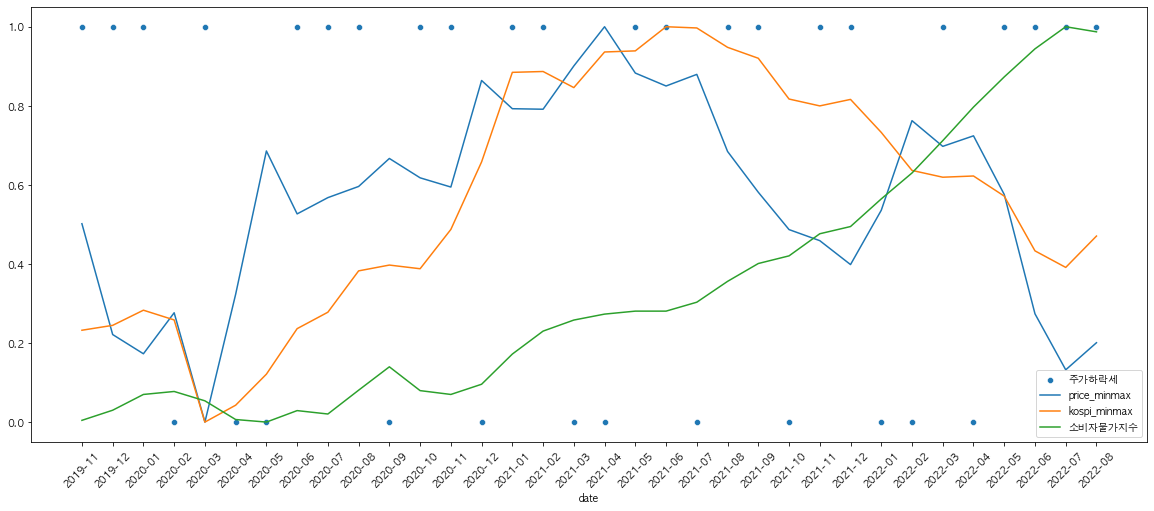

In [181]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="소비자물가지수", label='소비자물가지수')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

소비자 물가지수가 일정 지수(약 102) 이하 이면 하락세인 경향을 보인다. (검증 x, 버리죠)

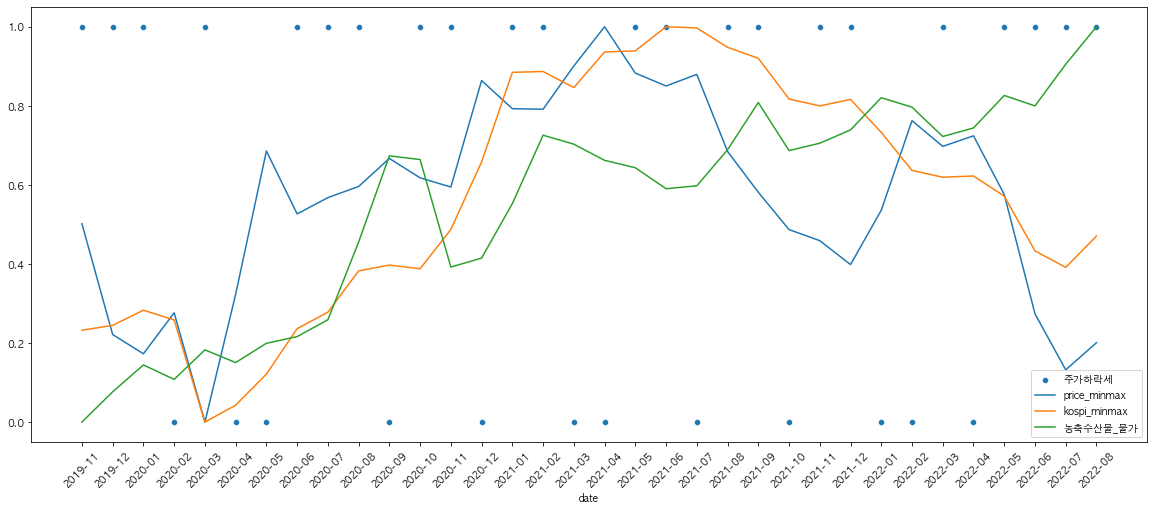

In [182]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="농축수산물_물가", label='농축수산물_물가')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

농축수산물 물가 상승시에 하락세인 경향을 보인다. (20년 2월, 21년 7월, 22년 4월) (검증)

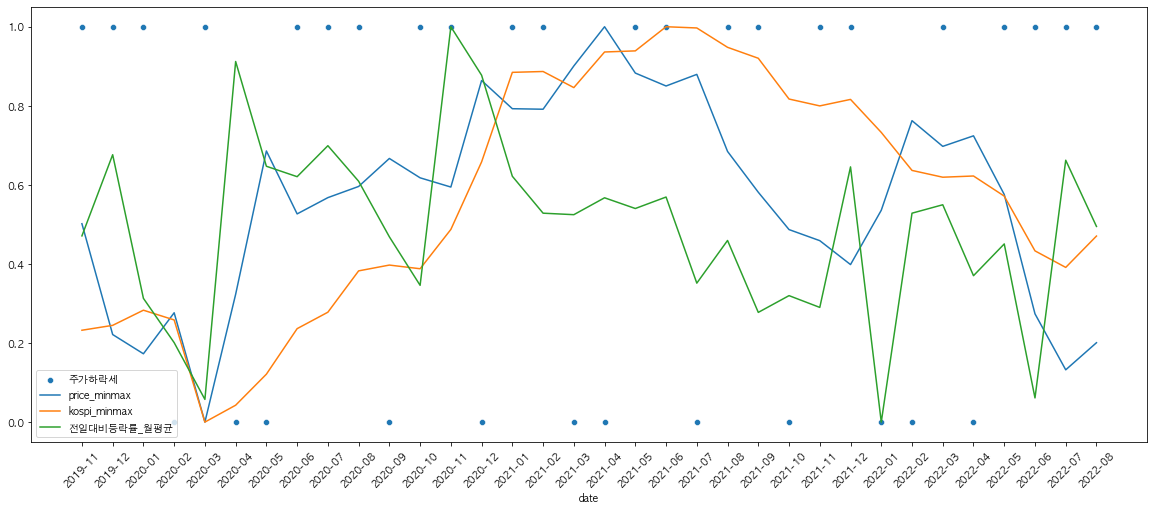

In [183]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="전일대비등락률_월평균", label='전일대비등락률_월평균')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

- kospi의 전일대비등락률의 월평균 값이 월간 0.45이상 차이 난다면 상승세와 하락세의 전환이 일어날 가능성이 높다. (여긴 버리죠)